Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ishikanisha","key":"385ff093e4c951baf149fd620871eaf3"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 801M/812M [00:07<00:00, 183MB/s]
100% 812M/812M [00:07<00:00, 116MB/s]


In [4]:
!unzip -qq dogs-vs-cats
!unzip -qq test1.zip
!unzip -qq train.zip

**Question1**. 

Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?




Splitting the dataset to 1000 for training,500 for validation, and 500 for testing

In [5]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

Training has 1000 samples, test has 500 samples and validation has 500 samples.

In [6]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

**Building the Model **

Separable convolution layers is the model we've chosen. We assume that various channels are substantially independent but intermediate activations are strongly connected while choosing this model.Adam is the optimizer we utilize. Also, because there is a risk of overfitting, we use both dropout layers and data augmentation at the conclusion.


In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


**Processing the data **

The quality of the data and the meaningful information that can be obtained from it directly influences our model's capacity to learn, hence this is an important phase in machine learning. Few steps are as follows Convert JPEG content to an RGB pixel grid, Create floating point tensors from an RGB grid of pixels,Scale them down Divide them into groups. The batch size we took is 32"""


In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Creating NumPy Array ofd 1000 samples with size=16

In [11]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [12]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [13]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [14]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Displaying the shape and labels

In [15]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Fitting the model using Datas

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30
63/63 [==============================] - 148s 2s/step - loss: 0.6988 - accuracy: 0.5085 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 144s 2s/step - loss: 0.6919 - accuracy: 0.5310 - val_loss: 0.6904 - val_accuracy: 0.5290
Epoch 3/30
63/63 [==============================] - 143s 2s/step - loss: 0.6857 - accuracy: 0.5410 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 143s 2s/step - loss: 0.6887 - accuracy: 0.5335 - val_loss: 0.6783 - val_accuracy: 0.5710
Epoch 5/30
63/63 [==============================] - 143s 2s/step - loss: 0.6621 - accuracy: 0.5985 - val_loss: 0.6511 - val_accuracy: 0.6020
Epoch 6/30
63/63 [==============================] - 142s 2s/step - loss: 0.6390 - accuracy: 0.6350 - val_loss: 0.6305 - val_accuracy: 0.6470
Epoch 7/30
63/63 [==============================] - 144s 2s/step - loss: 0.6324 - accuracy: 0.6380 - val_loss: 0.6249 - val_accuracy: 0.6450
Epoch 8/30
63

Displaying curves of loss and accuracy during training

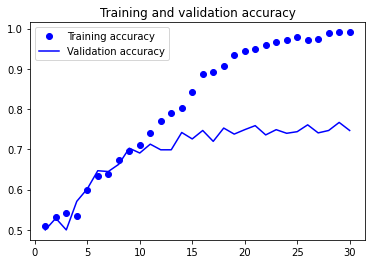

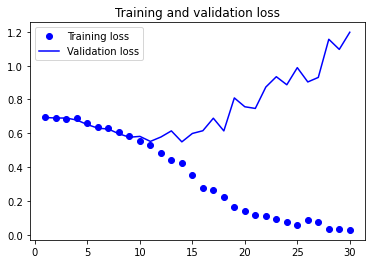

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


Model Evaluting in Test Dataset

In [18]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 18s 545ms/step - loss: 0.6060 - accuracy: 0.7040
Test accuracy: 0.704


"""**SUMMARY(1)** 

We can conclude that
1. the model accuracy is right line with the validation accuracy
2. the model starts to overfit at 9 ephoch
3. Training accuracy 99%
4. validation accuracy 74%
5. Test accuracy is 70% and loss is 60%
 
 We see that the model is training well on the training but after a certain point its overfitting, On the other hand validation and test accuracy is not improving a lot. The training sample of 1000 does not seem sufficient enough for model to reduces loss and increase accuracy. We need to use Data Augmentation and Dropout for reducing the overfitting.


**Question2** 

Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?



Increasing the traing dataset to 1500 and retraining the model

In [22]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


Displaying Randomly Augmented Training Images

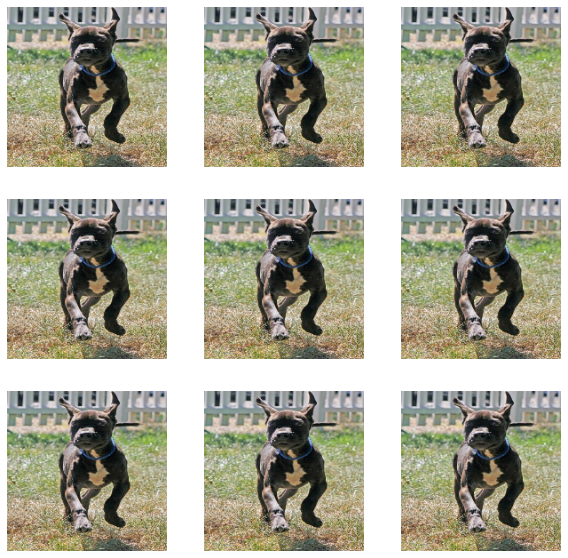

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


Defining a new convent that iuncludes image augmentation and dropout

In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


In [25]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


Training the regularized Convent

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/50
63/63 [==============================] - 158s 2s/step - loss: 0.6947 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 154s 2s/step - loss: 0.6939 - accuracy: 0.5230 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 153s 2s/step - loss: 0.6943 - accuracy: 0.4855 - val_loss: 0.6936 - val_accuracy: 0.4900
Epoch 4/50
63/63 [==============================] - 153s 2s/step - loss: 0.6937 - accuracy: 0.5100 - val_loss: 0.6922 - val_accuracy: 0.5010
Epoch 5/50
63/63 [==============================] - 153s 2s/step - loss: 0.6929 - accuracy: 0.5315 - val_loss: 0.6885 - val_accuracy: 0.5550
Epoch 6/50
63/63 [==============================] - 154s 2s/step - loss: 0.6900 - accuracy: 0.5255 - val_loss: 0.6894 - val_accuracy: 0.4890
Epoch 7/50
63/63 [==============================] - 153s 2s/step - loss: 0.6892 - accuracy: 0.5275 - val_loss: 0.6853 - val_accuracy: 0.5590
Epoch 8/50
63

We need to train our model using data augmentation and dropout technique for reducing overfitting


Evaluting model on test set

In [27]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 19s 557ms/step - loss: 0.4649 - accuracy: 0.8030
Test accuracy: 0.803


**SUMMARY(2)**
1. Test Accuracy - 80%
2. Training Accuracy= 85%
3. Validation Accuracy= 82%, 
4. loss= 46%

We can see that the accuracy went high, thus which in turn leads to reduction of overfitting
The best ways to avoid overfitting, as discovered by modifying the training sample and employing other optimization techniques, are as follows.
1.Increasing the training sample – Increasing the training sample isn't always achievable. One strategy for making the most of the limited training data is data augmentation, as done here

2.Reducing the network's capacity - When the model's size is lowered, i.e. the number of learnable parameters in the model, which is effectively the number of layers and units in layers, overfitting is considerably reduced.


**QUESTION 3**

Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

In [28]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)


In [29]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [30]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [31]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/50
63/63 [==============================] - 162s 3s/step - loss: 0.6939 - accuracy: 0.5130 - val_loss: 0.6859 - val_accuracy: 0.5140
Epoch 2/50
63/63 [==============================] - 157s 2s/step - loss: 0.6845 - accuracy: 0.5600 - val_loss: 0.6888 - val_accuracy: 0.5600
Epoch 3/50
63/63 [==============================] - 157s 2s/step - loss: 0.6720 - accuracy: 0.6045 - val_loss: 0.6670 - val_accuracy: 0.6060
Epoch 4/50
63/63 [==============================] - 156s 2s/step - loss: 0.6552 - accuracy: 0.6295 - val_loss: 0.6425 - val_accuracy: 0.6230
Epoch 5/50
63/63 [==============================] - 155s 2s/step - loss: 0.6463 - accuracy: 0.6370 - val_loss: 0.6614 - val_accuracy: 0.5950
Epoch 6/50
63/63 [==============================] - 154s 2s/step - loss: 0.6340 - accuracy: 0.6505 - val_loss: 0.6257 - val_accuracy: 0.6510
Epoch 7/50
63/63 [==============================] - 155s 2s/step - loss: 0.6081 - accuracy: 0.6700 - val_loss: 0.5883 - val_accuracy: 0.6800
Epoch 8/50
63

In [33]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


32/32 [==============================] - 18s 551ms/step - loss: 0.4388 - accuracy: 0.8380
Test accuracy: 0.838


**SUMMARY(3) **
1. Test Accuracy - 83%
2. Training Accuraccy - 89%
3. Validation Accuracy - 84%
4. loss - 43%
 
In step 3, I used a total of 2000 training samples with validation and 500 test samples. I noticed that when the training sample is 1500 photos, the test accuracy is higher than when the training sample is 1000 or 2000 images. When there are 1000 training samples, training accuracy improves. Increasing the training sample size to 2000 while retaining the validation and test sample sizes at 500.


**QUESTION 4**

Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.


Instantiating the VGG16 convolutional base

Fine-tuning is the process of unfreezing a few of the top layers of a frozen model foundation that are utilized for feature extraction and jointly training the newly added element of the model (in this case, the fully connected classifier) and these top layers. Fine-tuning is the process of modifying the more abstract representations of the model that are reused to make them more relevant to the job at hand.
"""

In [34]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))


58900480/58889256 [==============================] - 0s 0us/step


In [35]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Using a pretrained model, feature extraction without data augmentation is possible. Identifying the VGG16 characteristics and their labels


In [36]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

Defining and training the densely connected classifier

In [37]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 43ms/step - loss: 19.4241 - accuracy: 0.9220 - val_loss: 2.8211 - val_accuracy: 0.9780
Epoch 2/20
63/63 [==============================] - 2s 39ms/step - loss: 3.3207 - accuracy: 0.9785 - val_loss: 8.5880 - val_accuracy: 0.9580
Epoch 3/20
63/63 [==============================] - 2s 38ms/step - loss: 2.0218 - accuracy: 0.9850 - val_loss: 4.7745 - val_accuracy: 0.9740
Epoch 4/20
63/63 [==============================] - 2s 38ms/step - loss: 1.1945 - accuracy: 0.9885 - val_loss: 4.9070 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 2s 37ms/step - loss: 1.2197 - accuracy: 0.9920 - val_loss: 4.9451 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 2s 38ms/step - loss: 0.8962 - accuracy: 0.9930 - val_loss: 6.9625 - val_accuracy: 0.9710
Epoch 7/20
63/63 [==============================] - 2s 38ms/step - loss: 1.3024 - accuracy: 0.9915 - val_loss: 3.8924 - val_accuracy: 0.9840
Epoch 8/20
6

Results Plotting

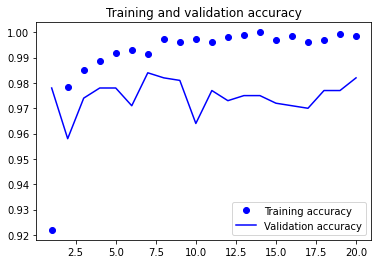

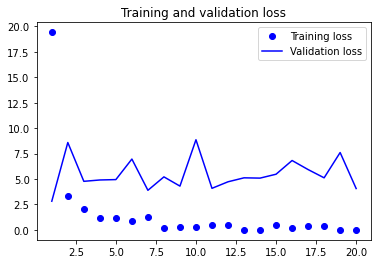

In [39]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Instantiating and freezing the VGG16 convolutional base


In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [41]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26


In [42]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights after freezing the conv base: 0


In [43]:
import tensorflow as tf
import tensorflow 

from tensorflow import keras
from keras.layers import Dense

To the convolutional base, adding a data augmentation stage and a classifier


In [44]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Due to long running time I am mentioning the results that i got from the following steps.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)


Using the test set to evaluate the model

In [ ]:
conv_base.summary()

All layers should be frozen until the fourth from the last

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


**SUMMARY(4)**

It is clear that the model is a bit better after frezzing some layers and retaining it.
1. test accuracy - 93%
2. training accuracy - 99%
3. validation accuracy - 96%




The size of the training sample and how we choose a network are critical, but it all depends on the settings we employ.
When we start training our model from the ground up, we can see that Trainig Sample Size is critical. By picking up the signals, large training samples aid our model's convergence.
The weights for the model are known ahead of time in the Pretrained Model. All we have to do now is feed it our data and wait for the results. However, this, too, may be improved. We can retrain the model by freezing parts of its layers.
We maintain the weights of some layers intact by freezing them. This allows us to save a significant amount of time and computing power.

We may train the model's final layers because they let the machine grasp some distinctive signals that are specific to the dataset. We can create a model that works flawlessly on unknown data and can be improved upon in the future
Using a model that has been pre-trained but hasn't been augmented
We acquire a validation accuracy of around 96% , which is higher than the accuracy we obtained when training the tiny model from start. When you use pre-trained features, this isn't always the case.

Despite using a high dropout rate, the graphs demonstrate that we're overfitting almost from the start. This is because this method does not use data augmentation, which is crucial for avoiding overfitting when working with small image datasets.
The Pre-trained model with precise adjustment has a test accuracy of 93%.